In [56]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from matplotlib import style
plt.style.use('/Users/edwardmu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/JGW.mplstyle')
from scipy.optimize import curve_fit
os.getcwd()

'/Users/edwardmu/OneDrive - Stanford/Classes/Chem 274 - Echem Lab/Project/Github/CHEM274-new/CHEM274-20211204'

In [74]:
data = pd.read_csv('data/CA_Fc_GC_MeCN_1.2V-0V_P-06-16/data.csv', sep=',')
data

,Unnamed: 0,E_program,Ecell,iw,t
0,0,1.2,1.200049,0.000007,0.000000
1,1,1.2,1.200378,0.000009,0.000278
2,2,1.2,1.199720,0.000009,0.000556
3,3,1.2,1.199720,0.000009,0.000833
4,4,1.2,1.200707,0.000009,0.001111
...,...,...,...,...,...
25195,25195,1.2,1.199720,0.000005,6.998611
25196,25196,1.2,1.200049,0.000006,6.998889
25197,25197,1.2,1.199720,0.000006,6.999167
25198,25198,1.2,1.200049,0.000006,6.999444


In [67]:
type(data)

pandas.core.frame.DataFrame

In [29]:
index_max = data['iw'].idxmax()
time_max = data.loc[index_max,'t']
print(time_max)

index_min = data['iw'].idxmin()
time_min = data.loc[index_min-1,'t']
print(time_min)

3.7888888888888888
0.7877777777777778


<AxesSubplot:xlabel='t'>

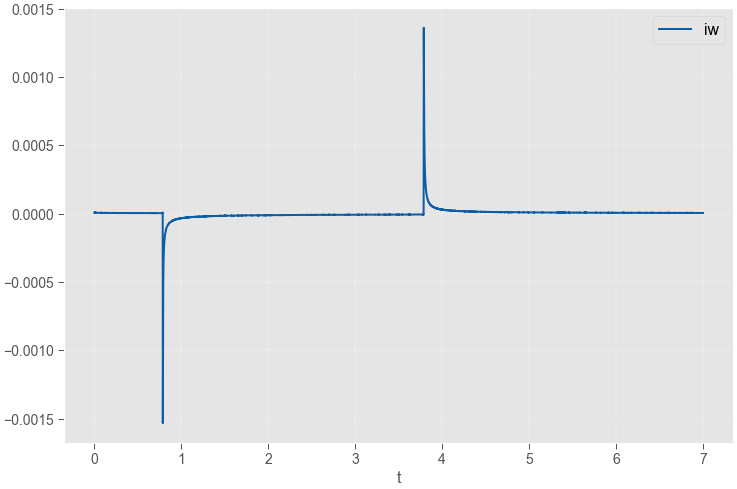

In [62]:
data.plot('t', 'iw')

In [31]:
# In E4, near optimal values of Rm and Cm were:
Rm = 10000 #10 kOhm
Cm = 100e-9 #100 nF
pstat_time_constant = Rm*Cm

# From an EIS spectrum of Fc in dry MeCN, Ru and Cdl are approximately:
Ru = 4.04e+02
Cdl = 3.93e-06
cell_time_constant = Ru*Cdl

#Value of the combined time constant tau

print(cell_time_constant + pstat_time_constant)

0.00258772


In [32]:
pot_step_time = time_min # step time start in s
pot_rest_time = time_max # rest time start in s

# For both of these capacitors to charge, we should ignore data before at least 5τ of each:
fit_start_time = pot_step_time + (5 * (cell_time_constant + pstat_time_constant))

# Fit until 5 ms before the rest step
fit_times = data[data['t'].between(fit_start_time, pot_rest_time - 0.005)]['t'].to_numpy()
fit_currents = data[data['t'].between(fit_start_time, pot_rest_time - 0.005)]['iw'].to_numpy()

fit_times_no_offset = fit_times - pot_step_time
#print(fit_times_no_offset)

a = -1.706E-05
D = 3.979E-06 cm^2 s^-1


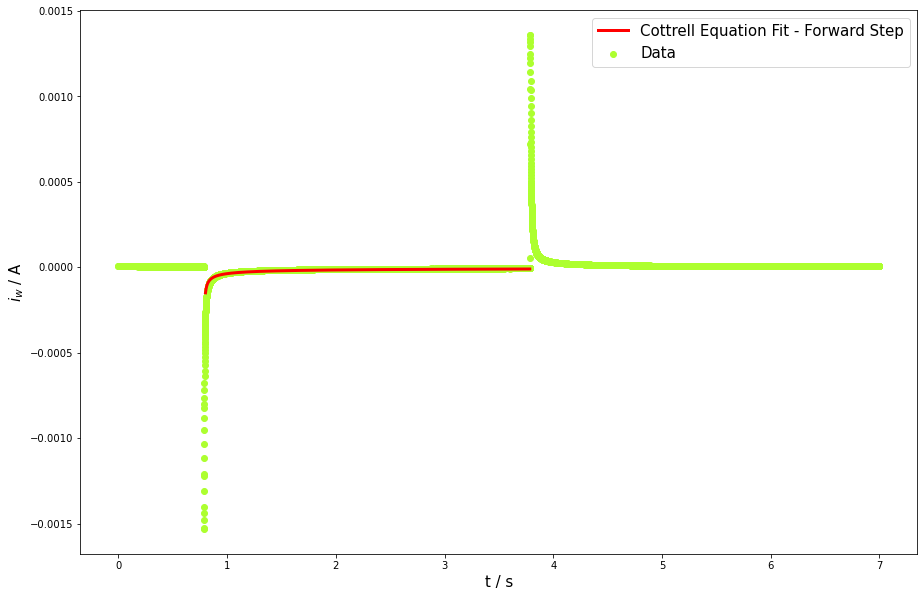

In [33]:
#Defines a function for curve_fit to fit to

def Empirical_Cottrell(t, a):
    return a / np.sqrt(t)

#Implementing curve_fit to solve for the empirical Cottrell prefactor a

guess_prefactor = 1e-10
fit_prefactor, cov = curve_fit(Empirical_Cottrell, fit_times_no_offset, fit_currents, guess_prefactor)
print('a = {0:.3E}'.format(fit_prefactor[0]))

#Calculating the diffusion constant D based on the fitted prefactor a, and the Cottrell Equation

a = fit_prefactor[0]
n = 1
F = 96485 #C/mol
A = np.pi*2.5**2/1000**2 #m^2
C_bulk = 0.8 #mol*m^-3 or mM
D = (a**2 * np.pi) / (n*F*A*C_bulk)**2 * 100**2 #cm^2/s
print('D = {0:.3E}'.format(D) + ' cm^2 s^-1')

#Plotting the chronoamperometry curve with the Cottrell Equation fit

fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(data['t'], data['iw'], label = 'Data', color = 'greenyellow')
ax.set_ylabel('$i_w$ / A', fontsize = 15)
ax.set_xlabel('t / s', fontsize = 15)
#ax.set_xlim(.99, 2.01)
ax.plot(fit_times, Empirical_Cottrell(fit_times_no_offset,a), color='red', label = 'Cottrell Equation Fit - Forward Step', linewidth=3)
ax.legend(fontsize = 15)

b = 1.687E-05
D = 3.891E-06 cm^2 s^-1


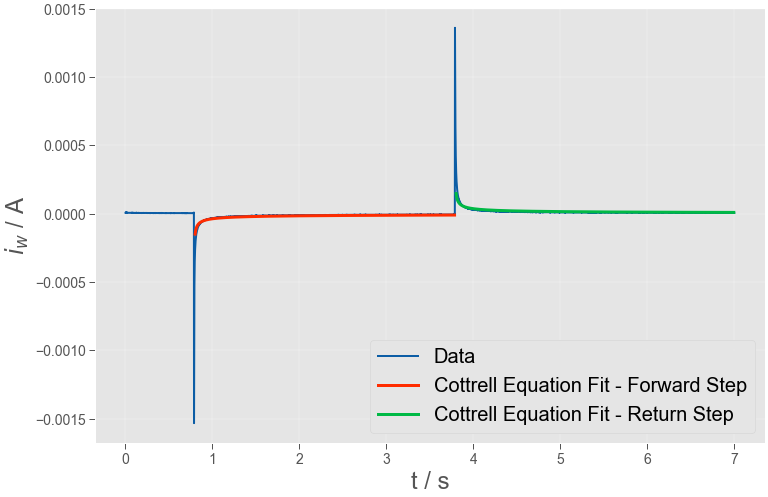

In [66]:
#Now Fitting the Return step.

pot_step_time_2 = time_max # step time start in s
pot_rest_time_2 = data.iloc[-1,-1] # rest time start in s

# For both of these capacitors to charge, we should ignore data before at least 5τ of each:
fit_start_time_2 = pot_step_time_2 + (5 * (cell_time_constant + pstat_time_constant))

# Fit until 5 ms before the rest step
fit_times_2 = data[data['t'].between(fit_start_time_2, pot_rest_time_2 - 0.005)]['t'].to_numpy()
fit_currents_2 = data[data['t'].between(fit_start_time_2, pot_rest_time_2 - 0.005)]['iw'].to_numpy()

fit_times_no_offset_2 = fit_times_2 - pot_step_time_2
fit_times_no_offset_2

#Implementing curve_fit to solve for the empirical Cottrell prefactor b

guess_prefactor_2 = 1e-10
fit_prefactor_2, cov_2 = curve_fit(Empirical_Cottrell, fit_times_no_offset_2, fit_currents_2, guess_prefactor_2)
print('b = {0:.3E}'.format(fit_prefactor_2[0]))

#Calculating the diffusion constant D based on the fitted prefactor b, and the Cottrell Equation

b = fit_prefactor_2[0]
n = 1
F = 96485 #C/mol
A = np.pi*2.5**2/1000**2 #m^2
C_bulk = 0.8 #mol*m^-2
D = (b**2 * np.pi) / (n*F*A*C_bulk)**2 * 100**2 #cm^2/s
print('D = {0:.3E}'.format(D) + ' cm^2 s^-1')

#Plotting the chronoamperometry curve with the Cottrell Equation fit

fig, ax = plt.subplots()#figsize = (15,10))
ax.plot(data['t'], data['iw'], label = 'Data')#, color = 'greenyellow')
ax.set_ylabel('$i_w$ / A', fontsize = 24)
ax.set_xlabel('t / s', fontsize = 24)
#ax.set_xlim(.99, 2.01)
ax.plot(fit_times, Empirical_Cottrell(fit_times_no_offset,a), label = 'Cottrell Equation Fit - Forward Step', linewidth=3)
ax.plot(fit_times_2, Empirical_Cottrell(fit_times_no_offset_2,b), label = 'Cottrell Equation Fit - Return Step', linewidth=3)
ax.legend(prop={'size': 20}, loc=0)

In [75]:
data

,Unnamed: 0,E_program,Ecell,iw,t
0,0,1.2,1.200049,0.000007,0.000000
1,1,1.2,1.200378,0.000009,0.000278
2,2,1.2,1.199720,0.000009,0.000556
3,3,1.2,1.199720,0.000009,0.000833
4,4,1.2,1.200707,0.000009,0.001111
...,...,...,...,...,...
25195,25195,1.2,1.199720,0.000005,6.998611
25196,25196,1.2,1.200049,0.000006,6.998889
25197,25197,1.2,1.199720,0.000006,6.999167
25198,25198,1.2,1.200049,0.000006,6.999444


In [76]:
data['t'].between(fit_start_time_2, pot_rest_time_2 - 0.005)

0        False
1        False
2        False
3        False
4        False
         ...  
25195    False
25196    False
25197    False
25198    False
25199    False
Name: t, Length: 25200, dtype: bool

In [77]:
data[data['t'].between(fit_start_time_2, pot_rest_time_2 - 0.005)]

,Unnamed: 0,E_program,Ecell,iw,t
13687,13687,0.0,1.200049,0.000316,3.801944
13688,13688,0.0,1.200049,0.000311,3.802222
13689,13689,0.0,1.200378,0.000306,3.802500
13690,13690,0.0,1.200378,0.000300,3.802778
13691,13691,0.0,1.200049,0.000295,3.803056
...,...,...,...,...,...
25177,25177,1.2,1.200707,0.000006,6.993611
25178,25178,1.2,1.200049,0.000006,6.993889
25179,25179,1.2,1.200049,0.000006,6.994167
25180,25180,1.2,1.200049,0.000006,6.994444


In [70]:
data[data['t'].between(fit_start_time_2, pot_rest_time_2 - 0.005)]['t']

13687    3.801944
13688    3.802222
13689    3.802500
13690    3.802778
13691    3.803056
           ...   
25177    6.993611
25178    6.993889
25179    6.994167
25180    6.994444
25181    6.994722
Name: t, Length: 11495, dtype: float64

In [72]:
data[data['t'].between(fit_start_time_2, pot_rest_time_2 - 0.005)]['t'].to_numpy()

array([3.80194444, 3.80222222, 3.8025    , ..., 6.99416667, 6.99444444,
       6.99472222])